In [143]:
## Packages to download the data 
import os 
import tarfile 
from six.moves import urllib

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

import hashlib
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline #, FeatureUnion 
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.externals import joblib 




from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Tags: 
## @interesting 
## @tip 

In [40]:
## 1. Frame the Problem
## - What is the business objective?
##      - How does the company expect to use and benefit from this model?
## - What does the current solution look like?
##      - Need a reference for performance and insights on how to solve problem
## - With current info, ready to design system ->
##      - Frame the problem: Is it a supervised, unsupervised... ML problem?...

In [41]:
## Fetch the data 
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path): # Create directory 
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") # Build download path
    urllib.request.urlretrieve(housing_url, tgz_path) # Download tar file to path (datasets/housing)
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) # Extract content to csv to path (datasets/housing)
    housing_tgz.close() # Close connection? 
    
## Load the data using Pandas 
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()

In [42]:
housing = load_housing_data()
housing.info() # @tip: get quick description of the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [43]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [44]:
## Look at categorical values in ocean_proximity: 
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [45]:
## Use the describe method to show a summary of all attributes - at least the numerical ones
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


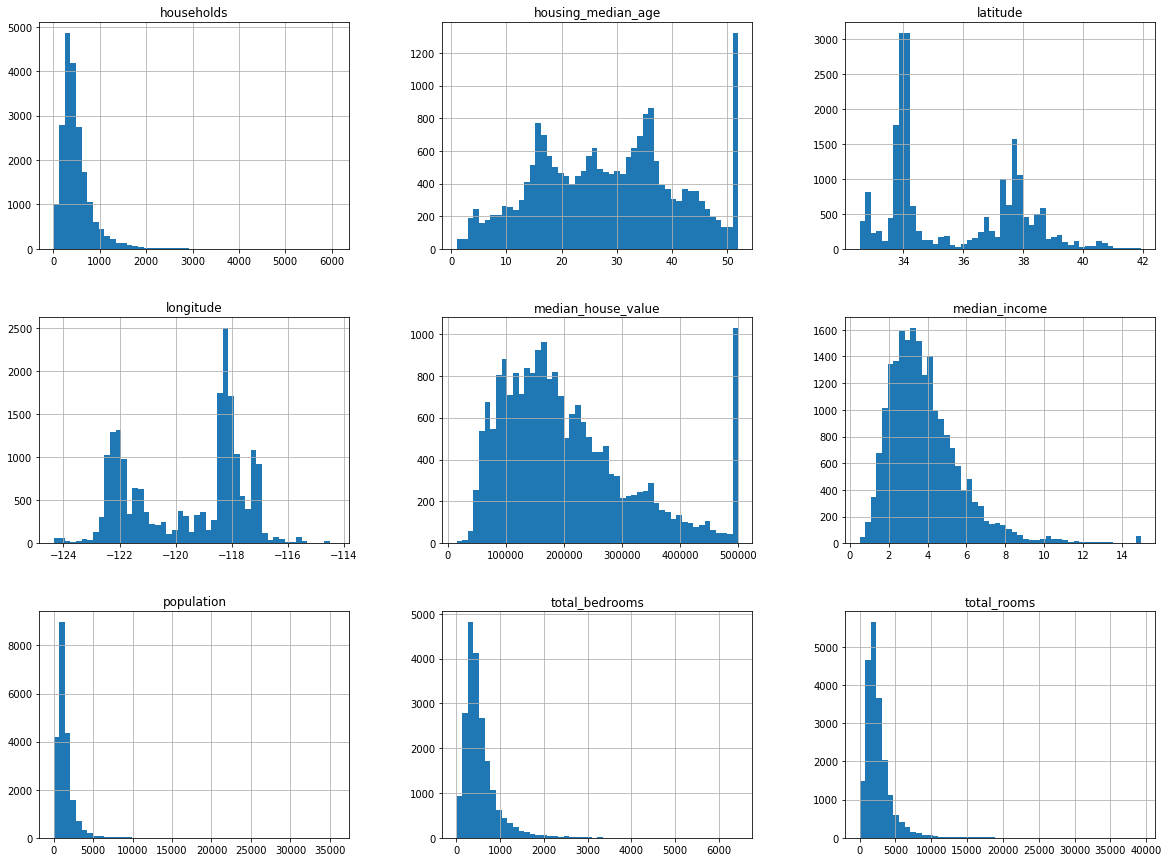

In [46]:
## Alternatively, plot histogram for numerical attributes 
## @tip using hist() function on the whole data frame will only plot the 
## ... numerical values 
housing.hist(bins = 50, figsize=(20,15))
plt.show() # Optional: In jupyter, will automatically show plots when cell is executed

# Notes: 
# - median_income doesn't seem to be expressed in $ 
#     - 15 is cap for max(median_income), .5 is cap for min(median_income)
# - Both median_house_value and median_income max-capped. 
# - total_bedrooms is the total # of roomsfor every district 
# - Very different scales for each attribute -> need to do feature scaling depending on model to use 
# - Long tails, right skew for a lot of these attributes. Need to normalize to get a more normal distribution

## Create a test set 

In [47]:
## Create a test set - to set aside for later model evaluation 
## Why set the test set aside before you've even done EDA: 
## Analyst can take into accounts interesting patterns in test set that leads to the ... 
## ... seletction of a particular ML model. Generalization error using test set ...
## ... will be too optimistic. This is called 'data snooping bias'

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    
## Problems with approach above: 
## Every time will rerun split_train_test, will get a different subset. 
## Eventually, model will see all of the data. 
## Solution: Find (or create) an identifier column 
## ... Here, we don't have an id column, lat and lon can be used instead 
## Important: need to compute a hash of each instance's identifier 
## ... keep only last byte of the hash, put instance in test set based on hash
## ... In case of sha256 with 256 bits, can use ~20% of 256 = 51
def test_set_check(identifier, test_ratio, hash):
    ## Get hash, take last byte, check if less than 51 (256 ( test_ratio))
    return (hash(np.int64(identifier)).digest()[-1] < (256 * test_ratio))


def split_train_set_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    ## For every id, check if last byte of hash of id is less than 51 
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]
    
    
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_set_by_id(housing_with_id, 0.2, "id")


In [48]:
## Stratified Shuffle Split 
## Why strat split: 
## When your data set is not large enough, want to ensure that your sample is 
## ... representative of the entire population

## Let's say that the median house income is representative of the median 
## ... housing price. The feature is a continuous variable -> categorize. 

## Current max of median income is 15 -> Categorize from 1-5, anything above 5 
## ... set to 5 
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'] = np.where(housing['income_cat'] > 5, 5, housing['income_cat'])

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state = 42) # strat. split setup 
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
## Examine proportions to make sure that strat sampling worked properly 
print(round(strat_train_set['income_cat'].value_counts() / len(strat_train_set) * 100,2))
print(round(strat_test_set['income_cat'].value_counts() / len(strat_test_set) * 100,2))
print(round(housing['income_cat'].value_counts() / len(housing) * 100,2))

## Don't forget to drop the income_cat col 
for set in (strat_train_set, strat_test_set): 
    set.drop('income_cat', axis =1, inplace = True)



3.0    35.06
2.0    31.89
4.0    17.63
5.0    11.44
1.0     3.98
Name: income_cat, dtype: float64
3.0    35.05
2.0    31.88
4.0    17.64
5.0    11.46
1.0     3.97
Name: income_cat, dtype: float64
3.0    35.06
2.0    31.88
4.0    17.63
5.0    11.44
1.0     3.98
Name: income_cat, dtype: float64


## Discovering and visualizng data to gain insights 

In [49]:
## Discovering and visualizng data to gain insights 
## Set aside a copy of TRAINING! data to look for correlations and .. 
## ... other patterns in the data 
housing = strat_train_set.copy() 

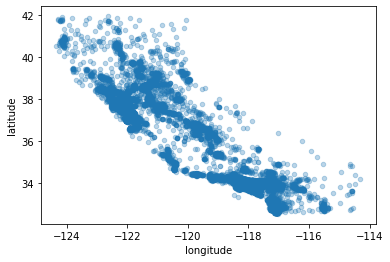

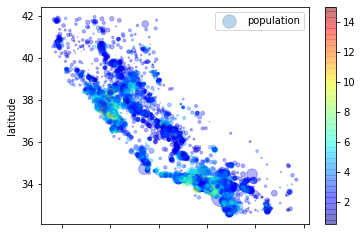

In [50]:
## Plot the lat lonng of observations 
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = .3)

## Also add population + color to the equation 
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = .3, 
            s = housing['population']/100, label = 'population', 
            c = housing['median_income'], cmap = plt.get_cmap('jet'), 
            colorbar = True)

In [51]:
## Looking for correlations
## Calculate correlation matrix, plot scatter plot of multiple vars and 
## ... plot scatter plot between prominent attribute and predictor 

correlation_matrix = housing.corr()
correlation_matrix['median_house_value'].sort_values(ascending = True) ## Take a closer look at median income 

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

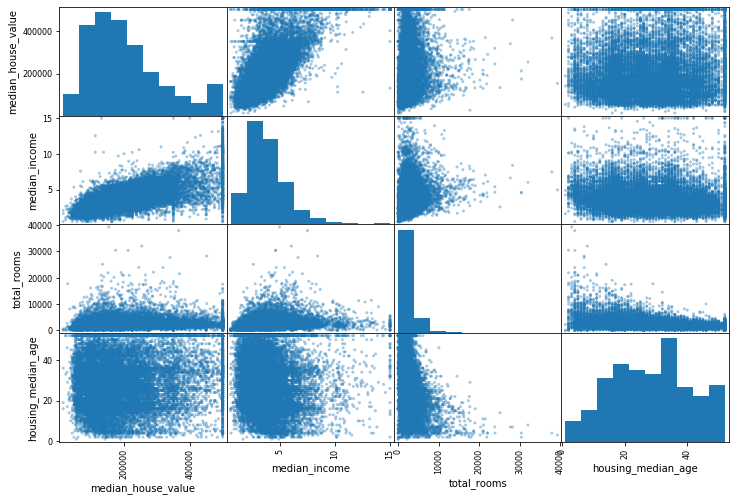

In [52]:
## Scatter plot 
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12,8), alpha = .4); ## Take a closer look at median_income

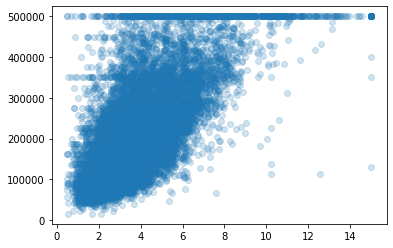

In [53]:
plt.scatter(data = housing, x = 'median_income', y = 'median_house_value', alpha = .2); ## Ceiling of 500k, horizontal limits at 350, 250 etc... 

In [54]:
## Experiment with attribute combinations - Feature engineering 
### @interesting: can deal with data skewness, outliers etc with transformations 
## But how can you make one variable more 'usable'? 
## e.g. # of rooms in it by itself may not useful by itself --> look at # of rooms per household 

## Transform and look at correlation again: 
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = True)

bedrooms_per_room          -0.259984
latitude                   -0.142724
longitude                  -0.047432
population                 -0.026920
population_per_household   -0.021985
total_bedrooms              0.047689
households                  0.064506
housing_median_age          0.114110
total_rooms                 0.135097
rooms_per_household         0.146285
median_income               0.687160
median_house_value          1.000000
Name: median_house_value, dtype: float64

## Preparing Data for ML Algos 

In [55]:
## Create functions 
## . Easy to reproduce transformations on any project 
## . Gradually build library of transformation functions for reuse in other projs 
## . Use the functions in live system 
## . Enables testing and experimentation 

## Copy train set again and separate predictor and response 
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy() ## @important don't forget to copy here! Otherwise pointing to strat_train_set 

## 1. Data cleaning 
## Replace missing values 

## Can either get rid of observations, column or impute (say with median value) 
## Store the median value so that it can be used later to impute missing values in test set / in live system 
median_total_bedroom = housing['total_bedrooms'].median() 
housing['total_bedrooms'].fillna(median_total_bedroom, inplace = True)

## Alternatively, can create an Imputer instance
imputer = SimpleImputer(strategy='median')

## Imputer can only work with dataframe that has numerical variables
housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)
print('Imputer stats:',imputer.statistics_)
print('Df median values:',housing_num.median().values)

## Use the trained imputer to transform training set: 
housing_tr = pd.DataFrame(imputer.transform(housing_num), columns = housing_num.columns)

Imputer stats: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Df median values: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [56]:
## Handling Categorical / Text Attributes 
## Again, use sklearn object to encode categorical variable to numerical 

## @note about scikit-learn design: 
## All objects share same interface: 
## - Estimators: Estimates parameters based on some dataset. Uses the fit() method 
## .... Needs to be set as an instance variable, via a constructor parameter 
## - Transformers: Some estimators can also transform a dataset 
## - Predictors: Some estimators can make predictions

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
# @note: can access hyperparams and learned parameters
# ... the latter are usually instance variables with an underscore suffix as seen below: 
print(encoder.classes_) 

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [57]:
## Cons of above solution: 
## An order is given to the categorical values 
## i.e. ML algo will assume that two consecutive values are 
## are more similar than two distant values 
## ----
## Instead, use one-hot encoding, where one bit is turned on 
## for every different attribute: 

ohe = OneHotEncoder(handle_unknown='ignore')
ohe_matrix = ohe.fit_transform(housing['ocean_proximity'].values.reshape(-1,1))

## A sparse matrix is returned - only returning non zero values 
## To convert to array: 
# ohe_matrix.toarray()


## Alternatively, can use a LabelBinarizer 
## Does the categorical -> integer -> one hot encoding all in one 

In [93]:
## Custom Transformers 

## To create a custom transformer, all you need is to create a class and implement 
## .. the 3 methods mentioned above: fit(), transform() and fit_transform() 
## Add BaseEstimator as base class to have two extra methods -> getter and setter 

## Example transformer class: 

room_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): ## Hyperparam allows to easily toggle attribute on or off 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self ## do nothing 
    def transform(self, X, y=None):
        rooms_per_household = X[:,room_ix] / X[:,household_ix]
        population_per_household = X[:,population_ix] / X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,room_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room] # np.c_ Translates slice objects to concatenation along the second axis.
        else: 
            return np.c_[X,rooms_per_household,population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

In [59]:
## Feature Scaling 

## @note: 
## min max scaling, also called normalization, bounds the values between 0 and 1 
## Substract min of feature for every value and divide by (max - min)

## Standardization -> substract mean and divide by variance. Standardized .. 
## .. features have a mean of 0 and variane of 1. 

## Pros of min max: Useful for algorithms that work better with inputs that range 
## between 0-1 or other range 
## Con: Does not deal with outliers well. E.g have features with range 0-10 except 
## ... for a value = 150 (outlier) -> all values will be between 0 and 0.06 except 
## ... for outlier

## @important to fit transformers (MinMaxScaler or StandardScaler) only to training 
## .. data, for full dataset (test set). Only then can you transform training, test and 
## .. new data. 

In [60]:
## Transformation pipelines
## Can create a pipeline to build a sequence of transformers 
## All transformers, except the last one in the sequence, should have 
## a transform_fit() method. 
## The last transformer's methods get exposed (i.e if only has ...
## ... fit method then only fit()  gets exposed at ppline end)


## Create a transformer to extract columns from dataframe 
## before passing it to pipeline (they only handle numopy arrays)

# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self 
#     def transform(self, X):
#         return X[self.attribute_names].values

# ## Get the numerical and cat labels 
# num_attribs = list(housing_num)
# cat_attribs = ['ocean_proximity']
    
# ## Create pipeline for numerical values 
# ## .. impute median, use our attribute adder and scale values 
# num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(num_attribs)),
#     ('imputer', SimpleImputer(strategy = 'median')),
#     ('attribs_adder', CombinedAttributesAdder()),
#     ('std_scaler', StandardScaler())
# ])

# ## Create cat pipeline to select attribs and  apply label binarizer 
# cat_pipeline = Pipeline([
#     ('selector', DataFrameSelector(cat_attribs)),
#     ('label_binarizer', LabelBinarizer())
# ])


# ## Combined the two pipelines with FeatureUnion 
# ## Each ppline runs in // and when output is ready 
# ## .. the results are concatenated and returned 

# full_pipeline = FeatureUnion(transformer_list = [
#     ("num_pipeline", num_pipeline),
#     ('cat_pipeline', cat_pipeline)
# ])

# housing_prepared = full_pipeline.fit_transform(housing)


In [125]:
## Above is the older solution
## tried to transform different columns using a soluiton based on DataFrameSelector + FeatureUnion 
## Now preferable to use ColumnTransformer class. 
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)), ## Alternatively, can use scikit's functionaltransformer class 
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
#     ("cat", OneHotEncoder(), cat_attribs)
])



housing_prepared = full_pipeline.fit_transform(housing)

In [126]:
housing_prepared.shape

(16512, 11)

## Select and Train a Model 

In [128]:
## Training and Evaluating on Training Set 

## Testing a couple of models 
lin_reg = LinearRegression() # post transformation
lin_reg.fit(housing_prepared, housing_labels) # just the labels 


## @bug: One hot encoder not returning the same number of columns '
## Probably based on number of labels that are encountered in subset 
## Take a" random subset of the data 
n = 5#housing.shape[0]-1000
some_data = housing.iloc[:n]
some_labels = housing_labels.iloc[:n]
some_data_prepared = full_pipeline.fit_transform(some_data)


# some_data.shape
some_data_prepared.shape
# housing.shape

print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

## Look at RMSE 
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE:",lin_rmse)

Predictions: [203363.02313273 340165.52231082 225650.1056982   66481.2269799
 199294.72549996]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
RMSE: 69422.88161769879


In [129]:
## How about if we implement a basic decision tree model 
tree_reg = DecisionTreeRegressor() 
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse # 0.0 - overfitting 

0.0

In [136]:
## Use cross-validation to fit decision tree model 
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring = 'neg_mean_squared_error', cv = 10)
## Scores are returned, get the rmse of scores? 
tree_rmse_scores = np.sqrt(-scores)

## Look at results 
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Sd:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [71799.67376038 75408.06270626 74959.92102494 70934.75399327
 73192.85972695 74085.47210012 74661.87093942 71220.31359182
 72129.3628886  76547.04803807]
Mean: 73493.93387698385
Sd: 1827.3061011248415


In [137]:
## Try linear regression with cv 
lin_reg_cv_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                                   scoring = 'neg_mean_squared_error', cv = 10)
display_scores(np.sqrt(-lin_reg_cv_scores))

Scores: [67383.78417581 67985.10139708 72048.46844728 74992.50810742
 68535.66280489 71602.89821633 66059.1201932  69302.44278968
 72437.02688935 68368.6996472 ]
Mean: 69871.57126682388
Sd: 2630.4324574585057


In [140]:
## Try random forest - without cv 
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

rf_cv_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                   scoring = 'neg_mean_squared_error', cv = 10)
display_scores(np.sqrt(-rf_cv_scores))

/Users/elieharik/Desktop/Dev/Books/Python/HandsOnML/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [52499.67882518 50739.84864826 54023.68347512 56041.10040071
 52724.28977034 56992.74365317 51247.48584443 50985.90734258
 56288.53606699 54288.23760148]
Mean: 53583.151162825714
Sd: 2188.014872405056


In [ ]:
## @important 
## To save models, use pickle module or sklearn.externals.joblib 
# joblib.dump(forest_reg, 'rf_model.pkl')
# my_model_loaded = joblib.load('rf_model.pkl')

## Fine Tune Model 

In [144]:
## With sklearn's GridSearchCV 
## Alternatively, can use RandomizedSearchCV instead 
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]}, # First try the 3x4=12 combinations
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]} # Then try the 1x2x3=6 combs here
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels) ## cv + grid_search: 5*18 = 90 runs of rf 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [151]:
## Get the best results 
print("Best params:",grid_search.best_params_)

## To get best estimator: 
print("Best estimator:",grid_search.best_estimator_,'\n')

## Get the cv results: 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

Best params: {'max_features': 4, 'n_estimators': 30}
Best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 

67422.23970545533 {'max_features': 2, 'n_estimators': 3}
56539.309046697235 {'max_features': 2, 'n_estimators': 10}
54621.12676158599 {'max_features': 2, 'n_estimators': 30}
60925.67014752211 {'max_features': 4, 'n_estimators': 3}
54452.145624543045 {'max_features': 4, 'n_estimators': 10}
51832.777027985045 {'max_features': 4, 'n_estimators': 30}
59986.05581348342 {'max_features': 6, 'n_estimators': 3}
53643.93752812181 {'max_features': 6, 'n_estimators': 10}
52046.2

In [160]:
## Analyze best models and their errors 
feature_importances = grid_search.best_estimator_.feature_importances_

## Display the importance scores 
xtra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedroom_per_room']
# cat_one_attribs = list(encoder.classes_)
attributes = num_attribs + xtra_attribs + cat_one_attribs

sorted(zip(feature_importances, attributes), reverse = True)

[(0.36043556720648734, 'median_income'),
 (0.12141758839621189, 'pop_per_hhold'),
 (0.11226143527981323, 'bedroom_per_room'),
 (0.10825779762801493, 'longitude'),
 (0.10543193460513799, 'latitude'),
 (0.06252188032524612, 'rooms_per_hhold'),
 (0.052232206981070874, 'housing_median_age'),
 (0.019963788095241273, 'population'),
 (0.01958306371676678, 'total_rooms'),
 (0.019108256327593463, 'households'),
 (0.018786481438416127, 'total_bedrooms')]

In [163]:
## Evaluate Test Set System 
## Run full pipeline to transform (not fit transform!) data and evaluate final model on test set 
final_model = grid_search.best_estimator_
X_set = strat_test_set.drop('median_house_value', axis=1)
Y_set = strat_test_set['median_house_value'].copy()
test_set = full_pipeline.transform(X_set)
final_predictions = final_model.predict(test_set)
rmse = np.sqrt(mean_squared_error(Y_set,final_predictions))
rmse

83181.69171267132